In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import numpy as np
from tensorflow.keras import layers
import time

np.set_printoptions(linewidth=50000,precision=4,suppress=True)

## Revoilà l'attention

Pour plus de détail, lire le TP préliminaire [ici](https://drive.google.com/file/d/11Rz7xzj2UVpCnSCPU13OQDSX4ujxUQzr/view?usp=sharing)

### Implémentation

Le `mask` indiquera quels sont les produits scalaires que l'on va ignorer.

In [3]:
def attention(Q,V,K, mask):
    """
    Args:
        Q: query shape = (..., T,  depth_1)
        V: value shape = (..., S,  depth_2)
        K: key shape   = (..., S,  depth_1)

        mask: shape = (...,T,S)
    """
    QKt = tf.matmul(Q, K, transpose_b=True)   # (..., T, S)
    depth_1 = tf.cast(tf.shape(K)[-1], tf.float32)
    QKt/=tf.sqrt(depth_1)

    if mask is not None:
        QKt += (mask * -1e9)

    attention_weights = tf.nn.softmax(QKt, axis=-1) # (..., T, S)
    output = tf.matmul(attention_weights, V) #(...,T, depth_2)
    return output, attention_weights

### La technique du masque



Quand on regarde à l'intérieure de la fonction qui calcule l'attention, on voit:

    if mask is not None:
        QKt += (mask * -1e9)

Le masque est multiplié par -1e9 (proche de $-\infty$) puis additionné au score. Une fois passée au softmax, l'`attention_weight` des valeurs masqué vaut zéro.

Pour que l'opération soit valide il faut que `mask.shape` soit broadcastable sur `QKt.shape` qui vaut

    (batch_size,T,S)

pour une attention simple, et qui peut aussi valoir

    (batch_size,num_head,T,S)

dans le cas de la multi-attention.

### Illustration

Traçons les attentions pour un batch de 2 éléments, sans masque pour l'instant.

In [4]:
def plot_attention_simple( Q,VK, output, attention_weights):

  fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))

  ax.matshow(attention_weights)
  ax.set_xticks(range(len(VK)))
  ax.set_yticks(range(len(Q)))

  labels = [str(elem) for elem in VK]
  ax.set_xticklabels(labels, rotation=90)

  labels = [str(elem) for elem in Q]
  ax.set_yticklabels(labels)
  ax.set_xlabel("Value=Key")
  ax.set_ylabel("Query")

  res=ax2.matshow(output)
  ax2.axis("off")

  fig.colorbar(res)
  fig.tight_layout()

In [5]:
VK=np.random.randint(-1,2,[2,7,2]).astype(np.float32) #(batch_size, S, depth)
Q =np.random.randint(-1,2,[2,7,2]).astype(np.float32) #(batch_size, T ,depth)

In [6]:
output, attention_weights=attention(Q,VK,VK,None)
output.shape,attention_weights.shape

Premier élément du batch:

In [7]:
plot_attention_simple(Q[0,:,:],VK[0,:,:],output[0,:,:],attention_weights[0,:,:])

second élément du batch

In [8]:
plot_attention_simple(Q[1,:,:],VK[1,:,:],output[1,:,:],attention_weights[1,:,:])

### Le masque "look-ahead"

Il ne fonctionne que dans le cas où `T=S`. Ainsi les matrices des poids d'attentions sont carrées.

Le masque look-head c'est ceci:


In [9]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [10]:
look_ahead_mask=create_look_ahead_mask(7)
print(look_ahead_mask.numpy())
look_ahead_mask.shape,look_ahead_mask.dtype

Observons l'attention que cela produit sur les 2 éléments de mon batch

In [11]:
VK=np.random.randint(-1,2,[2,7,2]).astype(np.float32)
Q =np.random.randint(-1,2,[2,7,2]).astype(np.float32)

output, attention_weights=attention(Q,VK,VK,look_ahead_mask)
output.shape,attention_weights.shape

In [12]:
plot_attention_simple(Q[0,:,:],VK[0,:,:],output[0,:,:],attention_weights[0,:,:])

In [13]:
plot_attention_simple(Q[1,:,:],VK[1,:,:],output[1,:,:],attention_weights[1,:,:])

Tous les coefficients $(\alpha_{ts},s>t)$ sont nul. Ainsi:
$$
Q'_t = fonction( Q_t ,(V\!K)_{s\leq t})
$$

En particulier, quand on a des matrices $V\!K_1$ et $V\!K_2$ qui sont identiques jusqu'à $t$ mais diffèrent ensuite, les sorties respectives $Q'_1$ et $Q'_2$ coincident aussi jusqu'à $t$.





### Le teste de non anticipation

C'est la dernière phrase de la section précédente que l'on vérifie dans les cellules suivantes:

In [14]:
VK_1=np.random.randint(-1,2,[2,7,2]).astype(np.float32) #(batch_size,T, depth)
Q =np.random.randint(-1,2,[2,7,2]).astype(np.float32) #(batch_size, T ,depth)

In [15]:
output_1, attention_weights=attention(Q,VK_1,VK_1,look_ahead_mask)

In [16]:
def change_at_some_time(t,seq):
    batch,T,depth=seq.shape
    return tf.concat([seq[:,:t,:],tf.random.uniform([batch,T-t,depth])],axis=1)

VK_2=change_at_some_time(4,VK_1)


In [17]:
output_2, _=attention(Q,VK_2,VK_2,look_ahead_mask)
difference=output_1-output_2
difference[0]

C'est en vérifiant cela à toute les étapes de la construction du modèle que j'ai pu débugguer mon code.

### Masque de padding

Ici $T$ et $S$ peuvent différer.

In [18]:
batch_size=2
T=5
S=7
depth=3
Q= np.random.randint(-1,2,[batch_size,T,depth]).astype(np.float32)
VK=np.random.randint(-1,2,[batch_size,S,depth]).astype(np.float32)

Imaginons que les séquences de longueurs différentes soient regroupées dans un batch. Pour en faire un tenseur plein, on ajoute du padding.

In [19]:
#Les longueurs des 2 sequences du batch
lengths=np.array([4,6])

mask=np.zeros([batch_size,7])
for i in range(batch_size):
    #on met une valeur bidon à la fin
    VK[i,lengths[i]:,:]=-13
    #Un masque indiquant là où les valeurs sont non-significatives
    mask[i,lengths[i]:]=1

In [20]:
print(VK)

In [21]:
print(mask)

On a mis un padding avec des `-13`. Grâce au masquage, ces valeurs ne vont jamais intervenir dans le calcul de la sortie $Q'$.

Pour que le masque puisse être passé comme argument de `attention` il doit être broadcastable avec la shape des attention weights, à savoir:

     (batch,T,S)=(2,5,7)
     
On lui ajoute donc une dimensions.

In [22]:
mask=mask[:,np.newaxis,:]
mask.shape

In [23]:
output, attention_weights=attention(Q,VK,VK,mask)
output.shape,attention_weights.shape

In [24]:
plot_attention_simple(Q[0,:,:],VK[0,:,:],output[0,:,:],attention_weights[0,:,:])

In [25]:
plot_attention_simple(Q[1,:,:],VK[1,:,:],output[1,:,:],attention_weights[1,:,:])

Ainsi l'output produit n'a pas du tout été influencé par les valeurs bidons ajoutées à la fin de `VK`.

### Multi-tête

Plus d'explication [ici](https://colab.research.google.com/drive/11Rz7xzj2UVpCnSCPU13OQDSX4ujxUQzr#scrollTo=kmzGPEy64qmA)

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">



In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, depth, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.depth = depth

        assert depth % self.num_heads == 0

        self.head_size = depth // self.num_heads

        self.wv = tf.keras.layers.Dense(depth)
        self.wk = tf.keras.layers.Dense(depth)
        self.wq = tf.keras.layers.Dense(depth)

        self.dense = tf.keras.layers.Dense(depth)


    def split_heads(self, x):
        """Split the last dimension into (num_heads, head_size).
        Transpose the result such that the shape is (batch_size, num_heads, T, head_size)
        """
        batch_size,T,_=x.shape
        x = tf.reshape(x, (batch_size, T, self.num_heads, self.head_size))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q,v,k,mask=None):
        batch_size = tf.shape(q)[0]
        v = self.wv(v)  # (batch_size, S, depth)
        k = self.wk(k)  # (batch_size, S, depth)
        q = self.wq(q)  # (batch_size, T, depth)

        v = self.split_heads(v)  # (batch_size, num_heads, S, head_size)
        k = self.split_heads(k)  # (batch_size, num_heads, S, head_size)
        q = self.split_heads(q)  # (batch_size, num_heads, T, head_size)

        """
        la scaled_dot_product_attention est appliquée sur les différentes têtes.
        Cette fonction agit sur les deux dernières dimensions des tenseurs, qui sont  (seq_len_x, head_size)
        """

        scaled_attention, _ = attention(q,v, k,mask) #(batch_size, num_heads, T,  head_size)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, T, num_heads, head_size)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.depth))  # (batch_size, T, depth)

        return self.dense(concat_attention)  # (batch_size, T, depth)



batch_size=1
T=5
S=3
depth=10
num_heads=5

Q=tf.random.uniform([batch_size,T,depth])
K=tf.random.uniform([batch_size,S,depth])
V=tf.random.uniform([batch_size,S,depth])

Q_prime = MultiHeadAttention(depth, num_heads)(Q,V,K)

print(Q_prime.shape)


### Multi-tête de keras

Dingue, le multi-tête de keras ne fonctionne pas comme voulu: il ne passe pas le teste de non-anticipation.

In [27]:
head_size=5
num_heads=2
mha_keras=layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)
seq=tf.random.uniform([1,7,2])
mask=create_look_ahead_mask(7)
output=mha_keras(seq,seq,seq,mask)
output.shape

In [28]:
seq_=change_at_some_time(5,seq)
print(seq-seq_)
output_=mha_keras(seq_,seq_,seq_,mask)
print(output-output_)

Qui ne passe pas le test de non-anticipation. Mon bug venait d'ici. Dans la doc j'ai pas trouvé d'explication. J'ai aussi testé en remplaçant `mask` par `1-mask` cela ne fonctionne pas non plus.

***A vous:*** Vérifiez que notre layer `MultiHeadAttention` passe le test de non-anticipation.

## Architecture du modèle


Le modèle complet est composé de block. On va commencer par décrire un block.

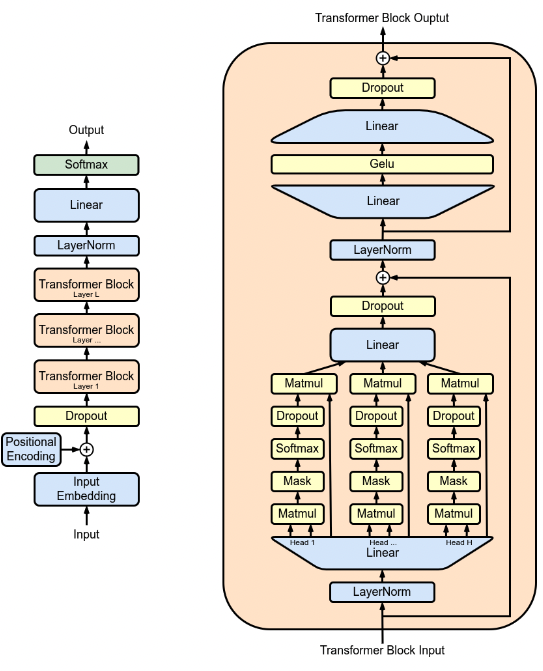

### Layer normalisation

Soit $x$ un tenseur de shape `(batch_size,...,depth)`. Imaginons que c'est la sortie d'un layer qu'on aimerait faire passer comme entrée du layer suivant.

Les layer n'aiment pas trop les tenseurs avec des valeurs trop petites ou trop grandes. Il existe deux types de normalisation:

* Batch normalisation: on centre-réduit avec les moyennes et écart-type calculés le long de l'axe 0 (celui de longueur `batch_size`). Cette normalisation pose quelque problèmes, car les tailles de batch peuvent varier. Typiquement, en mode production, on peut avoir à évaluer le modèle sur une seule donnée, donc `batch_size=1`.

* Layer normalisation. On centre-réduit avec les moyennes et écart-type calculés le long de l'axe -1 (celui de longueur `depth`).



### Feedforward

Le mot "FeedForward" (`FF`) est synomime de "Dense" ou de "FullyConnected". C'est donc un réseau dense à plusieurs couche que l'on va appliquer suivant le dernier axe (de taille `depth`).

On utiliser un réseau à 2 couches:

        layer1(x) = activation(x@w1+b1)
        layer2(x) = activation(x@w2+b2)

        FF(x) = layer2(layer1(x))
avec

        (x@w)[b,t,j] = sum_i x[b,t,i]w[i,j]



### Un block, 3 variantes

Nous allons maintenant définir le block de base d'un réseau transformer.

Notons `mha(x)=multi_head_attention(x,x,x,mask_look_ahead)` la couche de self-attention. Notons `|x|=layer_normalization(x)`. Voici les différentes variantes que l'on va tester:


Variante 1:  normalization à la fin: utilisée dans le tutorial de tensorflow sur les transformers

    block(x):
        h = mha(x)+x
        return | FF(|h|) + x |


Variante 2: Version avec racourci directe

    block(x):
        h = mha(|x|)+x
        return FF(|h|) + x

Variante 3: normalisation intérieure.

    block(x):
        h=mha(|x|)+x
        return FF(|h|) + h


Et on pourrait en imaginez d'autres


In [29]:
class SelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim,variante=1):
        super().__init__()

        self.variante=variante

        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ff1=layers.Dense(ff_dim, activation="relu")
        self.ff2=layers.Dense(d_model) #pour retrouver le même d_model

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    def call(self,x,mask):
        if self.variante==1:
            return self.call_1(x,mask)
        elif self.variante==2:
            return self.call_2(x,mask)
        else:
            return self.call_3(x,mask)


    def call_1(self, x, mask):#normalization after

        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ff2(self.ff1(out1))  # (batch_size, input_seq_len, d_model)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2



    def call_2(self,X,mask):

        X_nor=self.layernorm1(X)

        Y  =self.mha(X_nor,X_nor,X_nor,mask)+X

        Y_nor=self.layernorm2(Y)

        FF=self.ff2(self.ff1(Y_nor))

        return FF+X


    def call_3(self,X,mask):

        X_nor=self.layernorm1(X)

        Y  =self.mha(X_nor,X_nor,X_nor,mask)+X

        Y_nor=self.layernorm2(Y)

        FF=self.ff2(self.ff1(Y_nor))

        return FF+Y




#test
d_model=12
seq=tf.random.uniform([1,7,d_model])
mask=create_look_ahead_mask(7)
for variante in [1,2,3]:
    one_block=SelfAttentionBlock(d_model,2,64,variante)
    output=one_block(seq,mask)
    print(output.shape)

### Empilement des blocks

On commence par une projection qui transforme les données d'entrées en des vecteurs de taille `d_model`: la dimension qu'on a choisit pour tous les vecteurs internes au modèle. Plus elle est grosse, plus le modèle a une grosse capacité d'apprentissage.

In [30]:
class ModelTransformerPredictor(tf.keras.Model):
    def __init__(
        self,
        d_model,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units, #une liste d'entier
        variante=1
    ):

        super().__init__()
        self.variante=variante


        self.embeding=tf.keras.layers.Dense(d_model)

        self.blocks=[]
        for _ in range(num_transformer_blocks):
            self.blocks.append(SelfAttentionBlock(d_model,num_heads,ff_dim,self.variante))

        self.dense_layers=[]
        for dim in mlp_units:
            self.dense_layers.append(layers.Dense(dim, activation="relu"))

        self.final_layer=layers.Dense(1)


    def call(self,X):

        #rappel: le masque passer dans le model doit être broadcastable à (...,seq_len,seq_len)
        mask=create_look_ahead_mask(X.shape[1])[tf.newaxis,tf.newaxis,:,:] #(1,1,seq_len,seq_len)

        Y=self.embeding(X)
        for block in self.blocks:
            Y=block(Y,mask)

        for dense in self.dense_layers:
            Y=dense(Y)

        return self.final_layer(Y)

#test de non anticipation
def test():
    seq=tf.random.uniform([1,10,1])
    seq_=change_at_some_time(5,seq)

    for variante in [1,2,3]:
        model=ModelTransformerPredictor(d_model=20,num_heads=4,ff_dim=5,num_transformer_blocks=2,mlp_units=[4],variante=variante)
        output=model(seq)
        output_=model(seq_)
        print(output-output_)
test()

## Comparez

***A vous:*** Comparez ce que l'on vient de coder avec le schéma ci-dessous. Laquelle de nos variantes (1,2,3) est la plus proche? Et qu'est-ce qu'on a en moins?

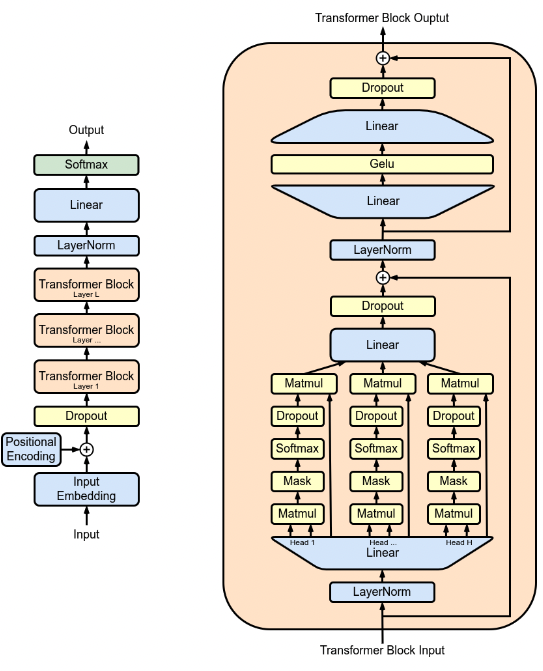

### Non-anticipation sur l'ensemble du modèle

Le modèle que l'on va construire doit prédire le futur $\delta$ pas de temps à l'avance (ex: $\delta=1$). Autrement dit:

 > A la $t$-ième étape de mon algo, je dois prédire ce qui va se passer au temps $t+\delta$.

Ainsi l'input $X$ et l'output attendu $Y$ sont reliés par
$$
Y_t = X_{t+\delta}
$$


Mais pour ne pas tricher, la prédiction doit "vivre dans son temps" càd que le modèle doit satisfaire:
$$
{model(X)}_t = fonc(X_s : s \leq t)
$$








Vérifions cela sur le modèle que nous venons de construire.

* L'attention masquée par le masque triangulaire a la proriété:
$$
attention(Q,V,K)_t = fonc[Q_t,(V_s)_{s\leq t},(K_s)_{s\leq t} ]
$$
* Du coup:
$$
mha(x)_t = fonc[(x_s)_{s\leq t}]
$$
* Vérifiez maintenant que les 3 variantes de block satisfont:
$$
block(x)_t = fonc[(x_s)_{s\leq t}]
$$
* Et finalement, la composition des blocks a cette même propriété.







## Data bruits de moteurs


Commençons par tester notre modèle de prédiction sur un jeu de données tout simple: des enregistrements de bruits de moteurs.

### Download

In [31]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    seq = data[:, 1:].astype(np.float32)
    return seq

root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

SEQ_TRAIN = readucr(root_url + "FordA_TRAIN.tsv")[:,:,np.newaxis]
SEQ_TEST  = readucr(root_url + "FordA_TEST.tsv")[:,:,np.newaxis]
OFFSET=10

In [32]:
nb=5
fig,axs=plt.subplots(nb,1)
for  i in range(nb):
    axs[i].plot(SEQ_TRAIN[i,:])

### creation de X,Y

In [33]:
def make_X_Y(seq,offset):
    x=seq[:,:-offset]
    y=seq[:,offset:]
    return x,y

In [34]:
def test():
    x,y=make_X_Y(SEQ_TRAIN,OFFSET)
    fig,ax=plt.subplots(figsize=(10,2))
    plt.plot(x[0,:,0],label="x")
    plt.plot(y[0,:,0],label="y")
    plt.legend();
test()

***A vous:*** Vérifiez que le décalage est dans le bon sens (c'est toujours un peu trompeur). Vous pouvez repartir de la phrase:

 > A la $t$-ième étape de mon algo je dois prédire ce qui va se passer au temps $t+\delta$.

### Un générateur de batch

Nous utilisons l'objet `tf.data.Dataset` pour distribuer nos batch.

In [35]:
def create_batch_dealer(seq,batch_size):
    ds=tf.data.Dataset.from_tensor_slices(seq)
    return iter(ds.shuffle(1000).batch(batch_size).repeat())

In [36]:
batch_dealer_example=create_batch_dealer(SEQ_TRAIN,3)
next(batch_dealer_example)

## Entrainement

### Trainer

In [37]:
from IPython.display import clear_output

class Trainer:

    def __init__(self, batch_dealer_train, batch_dealer_test, predictor,offset,loss_fn):

        self.batch_dealer_train=batch_dealer_train
        self.batch_dealer_test=batch_dealer_test
        self.predictor = predictor
        self.offset=offset
        self.loss_fn=loss_fn

        self.train_losses = []
        self.val_losses = []
        self.train_acc=[]
        self.val_step_ind=[]

        self.step=-1

        self.optimizer = tf.keras.optimizers.Adam(1e-4)

        seq=next(self.batch_dealer_train)
        self.seq_len=seq.shape[1]-self.offset


    @tf.function
    def train_step(self,x,y):

        with tf.GradientTape() as tape:
            pred = self.predictor(x)
            loss = self.loss_fn(y,pred)

        gradients = tape.gradient(loss, self.predictor.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.predictor.trainable_variables))

        return loss



    def val_step(self):
        batch=next(self.batch_dealer_test)
        x,y=make_X_Y(batch,self.offset)
        pred = self.predictor(x)
        val_loss = self.loss_fn(y,pred).numpy()

        print(f"Validation: step:{self.step}, val_loss:{val_loss:.3f}")
        self.val_losses.append(val_loss)
        self.val_step_ind.append(self.step)

        fig, axs = plt.subplots(1, 1, sharex="all")
        axs.plot(self.train_losses)
        axs.plot(self.val_step_ind,self.val_losses)
        axs.set_yscale("log")
        plt.show()


    def train(self, minutes_per_epoch):

        start = time.time()

        while time.time() - start < minutes_per_epoch * 60:
            self.step+=1
            batch=next(self.batch_dealer_train)
            x,y=make_X_Y(batch,self.offset)
            loss = self.train_step(x,y).numpy()

            self.train_losses.append(loss)

            clear_output(wait=True)
            if self.step%100==0:
                self.val_step()

        self.val_step()


### C'est parti

In [38]:
VARIANTE=3

batch_dealer_train=create_batch_dealer(SEQ_TRAIN,64)
batch_dealer_test=create_batch_dealer(SEQ_TEST,64)

model=ModelTransformerPredictor(d_model=256,num_heads=4,ff_dim=4,num_transformer_blocks=4,mlp_units=[128],variante=VARIANTE)

trainer=Trainer(batch_dealer_train,batch_dealer_test,model,OFFSET,lambda y,pred:tf.reduce_mean((y-pred)**2))

In [39]:
trainer.train(3)

Voici un exemple d'apprentissage qui c'est pas bien passé. Qu'est-ce qu'il aurait fallu ajouté comme option pour pouvoir récupérer quand même un bon modèle à la fin de cet entrainement ?

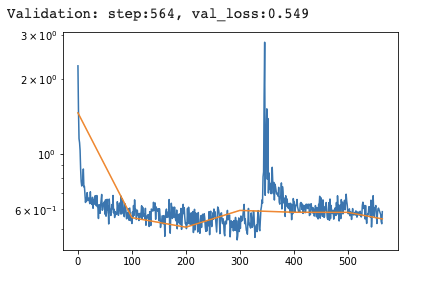

### Evaluation

In [40]:
def evaluate_with_plot(zoom=50):

    #il faut prendre un batch-size assez grand pour que l'erreur ne varie pas trop quand on change de batch
    #mais très vite on a des problèmes de mémoire ; par exemple pour les masques de shape (batch_size,1,seq_len,seq_len)
    batch_dealer=create_batch_dealer(SEQ_TEST,10)
    batch=next(batch_dealer)
    x,y=make_X_Y(batch,OFFSET)

    seq_len=x.shape[1]

    pred = model(x)

    ind = tf.range(seq_len)
    nb = 5
    assert nb<len(x)

    def plot(zoom):
        fig, axs = plt.subplots(nb, 1,figsize=(15,10))
        for i in range(nb):
            if zoom !=-1:
                axs[i].plot(ind[:zoom], x[i, :zoom, 0], label="input")
            axs[i].plot(ind[:zoom], pred[i, :zoom, 0], label="pred")
            axs[i].plot(ind[:zoom], y[i, :zoom,0],label="true")

        axs[0].legend()

    plot(-1)
    plot(zoom)
    plt.show()


evaluate_with_plot()

Pour l'évaluation, il faut prendre un nombre d'exemples assez grand, sinon notre évaluation sera hasardeuse.

Mais si l'on prend un `batch_size` trop grand,  on a des problèmes de mémoire à cause des tenseurs de shape `(batch_size,T,T)` qui sont utilisés pour l'attention. On va donc préférer faire des statistiques sur plusieurs batch.

In [41]:
def evaluate_relative_error():

    batch_dealer=create_batch_dealer(SEQ_TEST,100)
    res=[]
    for _ in range(50):
        batch=next(batch_dealer)
        x,y=make_X_Y(batch,OFFSET)

        seq_len=x.shape[1]

        pred = model(x)

        error_along_time = tf.reduce_mean(tf.abs(y - pred), axis=1)
        max_along_time = tf.reduce_max(tf.abs(y), axis=1)
        relative_error = tf.reduce_mean(error_along_time / max_along_time)

        res.append(relative_error.numpy())

    print("mean of errors",np.mean(res))
    print("std of erros",np.std(res))


evaluate_relative_error()

Aprés entrainement de 3 minutes:
* variante 1:
        mean of errors 0.17968377
        std of erros 0.006099828

* variante 2:

        mean of errors 0.1857056
        std of erros 0.006335868

* variante 3:

        mean of errors 0.19264233
        std of erros 0.0055565517




C'est vraiment kif kif.

La variante avec racourcis directe est un peu dangereuse car les données initiales traversent le réseaux sans être normalisées; il faut donc qu'elles ait un ordre de grandeur raisonnable au départ.  
